In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import linprog
from scipy.stats import wasserstein_distance as W1

In [134]:
# вариант с чтением из консоли, для тестирования наглядно
N = int(input("Введите количество вершин в графе: ")) # размер матрицы

M = np.zeros(shape = (N, N), dtype = float)
nums = list(map(float, input().split()))
for i in range(N):
    for j in range(N):
        M[i][j] = nums[i * N + j]
print(M)

Введите количество вершин в графе: 7
0 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
[[0. 1. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
#[0,1,1,1,1,0,1],[1,0,1,0,0,0,0],[1,1,0,0,0,0,0],[1,0,0,0,0,0,0],[1,0,0,0,0,1,0],[0,0,0,0,1,0,0],[1,0,0,0,0,0,0]]

In [3]:
def distances(M, N):
    d = np.array(M)
    for i in range(N):
        for j in range(N):
            if d[i][j] != 0:
                d[i][j] = 1
            else:
                d[i][j] = np.inf
        d[i][i] = 0
    for k in range(N):
        for i in range(N):
            for j in range(N):
                d[i][j] = min(d[i][j], d[i][k] + d[k][j])
    return d

In [4]:
def degree(M, N, index):
    d = 0.0
    for j in range(N):
        if index != j:
            d += M[index][j]
    return d

In [5]:
def get_m_p(M, N, p=0):
    M_1 = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        d = degree(M, N, i)
        for j in range(N):
            if i == j:
                M_1[i][j] = p
            elif M[i][j] != 0:
                M_1[i][j] = (1 - p) * M[i][j] / d
            else:
                M_1[i][j] = 0
    return M_1

In [6]:
def W1(M, N, m, d, i, j, p=0):
    nb_i = []
    nb_j = []
    for nb in range(N):
        if m[i][nb] > 0.0:
            nb_i.append(nb)
        if m[j][nb] > 0.0:
            nb_j.append(nb)
    c = np.zeros(len(nb_i) * len(nb_j))
    A_eq = np.zeros(shape=(len(nb_i) + len(nb_j), len(nb_i) * len(nb_j)))
    b_eq = np.zeros(len(nb_i) + len(nb_j))

    for nb_idx_i in range(len(nb_i)):
        b_eq[nb_idx_i] = m[i][nb_i[nb_idx_i]]
        for nb_idx_j in range(len(nb_j)):
            c[nb_idx_i * len(nb_j) + nb_idx_j] = d[nb_i[nb_idx_i]][nb_j[nb_idx_j]]
            A_eq[nb_idx_i][nb_idx_i * len(nb_j) + nb_idx_j] = 1.0
            A_eq[len(nb_i) + nb_idx_j][nb_idx_i * len(nb_j) + nb_idx_j] = 1.0

    for nb_idx_j in range(len(nb_j)):
        b_eq[len(nb_i) + nb_idx_j] = m[j][nb_j[nb_idx_j]]

    bounds = [(0, 1)] * len(c)
    
    return linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds).fun

In [7]:
def w1(M, N, m, d, i, j):
    p = []
    q = []
    for nb in range(N):
        #if m[i][nb] > 0.0:
        p.append(nb)
        #if m[j][nb] > 0.0:
        q.append(nb)
    C = d.reshape(-1)
    print('lens', len(p), len(q))
    obj = -np.concatenate([p, q])
    print('obj', type(obj), obj.shape)
    obj = matrix(obj)
    print('obj', isinstance(obj, matrix))
    C = matrix(C)
    print('C', type(C))
    n = len(p)
    values = [0] * (n * n * 2)
    rows = [0] * (n * n * 2)
    cols = [0] * (n * n * 2)
    for i in range(n):
        for j in range(n):
            index = i * n + j
            values[index * 2] = 1
            values[index * 2 + 1] = 1
            cols[index * 2] = i
            cols[index * 2 + 1] = n + j
            rows[index * 2] = index
            rows[index * 2 + 1] = index
    A = spmatrix(values, rows, cols)
    LP = solvers.lp(obj, A, C, solver='glpk')
    return LP['primal objective']

In [8]:
def curvature(M, p=0):
    N = M.shape[0]
    m = get_m_p(M, N, p)
    d = distances(M, N)
    K = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        for j in range(i):
            if M[i][j] != 0:
                K[i][j] = 1 - (W1(M, N, m, d, i, j, p) / d[i][j])
                K[j][i] = K[i][j]
    return np.around(K, decimals=8)

In [9]:
def get_m_x(M, N):
    M_1 = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        d = degree(M, N, i)
        p = 1 / (d + 1)
        for j in range(N):
            if i == j:
                M_1[i][j] = p
            elif M[i][j] != 0:
                M_1[i][j] = (1 - p) * M[i][j] / d
            else:
                M_1[i][j] = 0
    return M_1

In [10]:
def curvature_with_idleness(M, p=0):
    N = M.shape[0]
    m = get_m_x(M, N)
    d = distances(M, N)
    K = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        for j in range(i):
            if M[i][j] != 0:
                K[i][j] = 1 - (w1(M, N, m, d, i, j, p) / d[i][j])
                K[j][i] = K[i][j]
    return np.around(K, decimals=8)

In [11]:
def node_curvature(K, index, p=0):
    N = K.shape[0]
    cur = 0.0
    for i in range(N):
        if i != index:
            cur += K[index][i]
    return cur

In [12]:
def node_curvature_weighted(M, K, index, p=0):
    N = K.shape[0]
    d = degree(M, N, index)
    cur = 0.0
    for i in range(N):
        if i != index:
            cur += K[index][i]
    cur = cur * (M[index][i] / d)
    return cur

In [13]:
def graph_curvature(M, K, p=0):
    N = M.shape[0]
    cur = 0
    for i in range(N):
        cur += node_curvature(K, i, p)
    return cur

In [ ]:
def distances(M, N):
    d = np.array(M)
    for i in range(N):
        for j in range(N):
            if d[i][j] != 0:
                d[i][j] = 1
            else:
                d[i][j] = np.inf
        d[i][i] = 0
    for k in range(N):
        for i in range(N):
            for j in range(N):
                d[i][j] = min(d[i][j], d[i][k] + d[k][j])
    return d
def distances(M, N):
    d = np.array(M)
    for i in range(N):
        for j in range(N):
            if d[i][j] != 0:
                d[i][j] = 1
            else:
                d[i][j] = np.inf
        d[i][i] = 0
    for k in range(N):
        for i in range(N):
            for j in range(N):
                d[i][j] = min(d[i][j], d[i][k] + d[k][j])
    return d
def degree(M, N, index):
    d = 0.0
    for j in range(N):
        if index != j:
            d += M[index][j]
    return d
def get_m_p(M, N, p=0):
    M_1 = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        d = degree(M, N, i)
        for j in range(N):
            if i == j:
                M_1[i][j] = p
            elif M[i][j] != 0:
                M_1[i][j] = (1 - p) * M[i][j] / d
            else:
                M_1[i][j] = 0
    return M_1
def W1(M, N, m, d, i, j, p=0):
    nb_i = []
    nb_j = []
    for nb in range(N):
        if m[i][nb] > 0.0:
            nb_i.append(nb)
        if m[j][nb] > 0.0:
            nb_j.append(nb)
    c = np.zeros(len(nb_i) * len(nb_j))
    A_eq = np.zeros(shape=(len(nb_i) + len(nb_j), len(nb_i) * len(nb_j)))
    b_eq = np.zeros(len(nb_i) + len(nb_j))
​
    for nb_idx_i in range(len(nb_i)):
        b_eq[nb_idx_i] = m[i][nb_i[nb_idx_i]]
        for nb_idx_j in range(len(nb_j)):
            c[nb_idx_i * len(nb_j) + nb_idx_j] = d[nb_i[nb_idx_i]][nb_j[nb_idx_j]]
            A_eq[nb_idx_i][nb_idx_i * len(nb_j) + nb_idx_j] = 1.0
            A_eq[len(nb_i) + nb_idx_j][nb_idx_i * len(nb_j) + nb_idx_j] = 1.0
​
    for nb_idx_j in range(len(nb_j)):
        b_eq[len(nb_i) + nb_idx_j] = m[j][nb_j[nb_idx_j]]
​
    bounds = [(0, 1)] * len(c)
    
    return linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds).fun
def w1(M, N, m, d, i, j):
    p = []
    q = []
    for nb in range(N):
        #if m[i][nb] > 0.0:
        p.append(nb)
        #if m[j][nb] > 0.0:
        q.append(nb)
    C = d.reshape(-1)
    print('lens', len(p), len(q))
    obj = -np.concatenate([p, q])
    print('obj', type(obj), obj.shape)
    obj = matrix(obj)
    print('obj', isinstance(obj, matrix))
    C = matrix(C)
    print('C', type(C))
    n = len(p)
    values = [0] * (n * n * 2)
    rows = [0] * (n * n * 2)
    cols = [0] * (n * n * 2)
    for i in range(n):
        for j in range(n):
            index = i * n + j
            values[index * 2] = 1
            values[index * 2 + 1] = 1
            cols[index * 2] = i
            cols[index * 2 + 1] = n + j
            rows[index * 2] = index
            rows[index * 2 + 1] = index
    A = spmatrix(values, rows, cols)
    LP = solvers.lp(obj, A, C, solver='glpk')
    return LP['primal objective']
def curvature(M, p=0):
    N = M.shape[0]
    m = get_m_p(M, N, p)
    d = distances(M, N)
    K = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        for j in range(i):
            if M[i][j] != 0:
                K[i][j] = 1 - (W1(M, N, m, d, i, j, p) / d[i][j])
                K[j][i] = K[i][j]
    return np.around(K, decimals=8)
def get_m_x(M, N):
    M_1 = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        d = degree(M, N, i)
        p = 1 / (d + 1)
        for j in range(N):
            if i == j:
                M_1[i][j] = p
            elif M[i][j] != 0:
                M_1[i][j] = (1 - p) * M[i][j] / d
            else:
                M_1[i][j] = 0
    return M_1
def curvature_with_idleness(M, p=0):
    N = M.shape[0]
    m = get_m_x(M, N)
    d = distances(M, N)
    K = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        for j in range(i):
            if M[i][j] != 0:
                K[i][j] = 1 - (w1(M, N, m, d, i, j, p) / d[i][j])
                K[j][i] = K[i][j]
    return np.around(K, decimals=8)


In [143]:
def draw_graph(M, K = [[]], p=0, layout='circular'):
    N = M.shape[0]
    if K == [[]]:
        K = curvature(M, p)
    plt.figure(figsize = (8, 8))
    G = nx.Graph()
    labels = {}
    for i in range(N):
        labels[i] = 'v' + (str(i + 1))
    G.add_nodes_from([i for i in range(0, N)])
    for i in range(0, N):
        for j in range(i, N):
            if M[i][j] != 0:
                G.add_edge(i, j, weight = M[i][j])
    pos = nx.circular_layout(G)
    if layout=='spring':
        pos = nx.spring_layout(G)
    elif layout=='random':
        pos = nx.random_layout(G)
    elif layout=='planar':
        pos = nx.planar_layout(G)
    elif layout=='shell':
        pos = nx.shell_layout(G)
    elif layout=='spectral':
        pos = nx.spectral_layout(G)
    for i in range(0, N):
        cur = node_curvature(K, i, p)
        if cur > 0:
            nx.draw_networkx_nodes(G, pos,
                       nodelist=[i],
                       node_color='crimson',
                       node_size=min(250, 3000*cur),
                       alpha=1)
        elif cur < 0:
            nx.draw_networkx_nodes(G, pos,
                       nodelist=[i],
                       node_color='powderblue',
                       node_size=min(250,-3000*cur),
                       alpha=1)
        else:
            nx.draw_networkx_nodes(G, pos,
                       nodelist=[i],
                       node_color='gainsboro',
                       node_size=1000,
                       alpha=1)
        for j in range(i, N):
            cur = K[i][j]
            if M[i][j] != 0 and i != j:
                if cur > 0:
                    nx.draw_networkx_edges(G, pos, edgelist = [(i, j)], alpha=K[i][j], edge_color = 'crimson')
                    edge_labels = {(i, j) : str(cur)[:4]}
                    nx.draw_networkx_edge_labels(G, pos, edge_labels)
                elif cur < 0:
                    nx.draw_networkx_edges(G, pos, edgelist = [(i, j)], alpha=-K[i][j], edge_color = 'steelblue')
                    edge_labels = {(i, j) : str(cur)[:5]}
                    nx.draw_networkx_edge_labels(G, pos, edge_labels)
                else:
                    nx.draw_networkx_edges(G, pos, edgelist = [(i, j)], alpha=1)
                    edge_labels = {(i, j) : '0'}
                    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10, font_family='Verdana')
    nx.draw_networkx_labels(G, pos, labels, font_size=11, font_family='Verdana')
    plt.axis('off')
    plt.show()

<ipython-input-6-8d23b137a960>:25: OptimizeWarning:

A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.



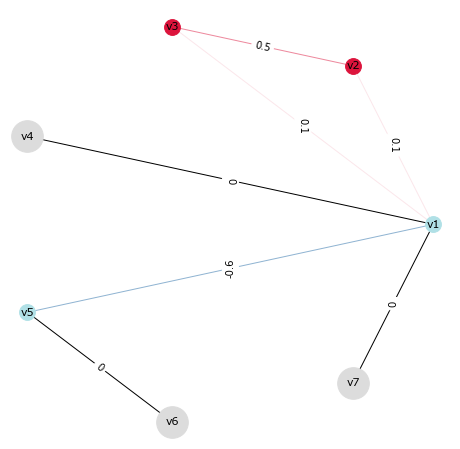

In [145]:
draw_graph(M)

In [149]:
def draw_graph(M, K=[[]], p=0, layout='circular'):
    N = M.shape[0]
    if K == [[]]:
        K = curvature(M, p)
    plt.figure(figsize = (8, 8))
    G = nx.Graph()
    labels = {}
    for i in range(N):
        labels[i] = 'v' + (str(i + 1))
    G.add_nodes_from([i for i in range(0, N)])
    for i in range(0, N):
        for j in range(i, N):
            if M[i][j] != 0:
                G.add_edge(i, j, weight = M[i][j])
    pos = nx.circular_layout(G)
    if layout=='spring':
        pos = nx.spring_layout(G)
    elif layout=='random':
        pos = nx.random_layout(G)
    elif layout=='planar':
        pos = nx.planar_layout(G)
    elif layout=='shell':
        pos = nx.shell_layout(G)
    elif layout=='spectral':
        pos = nx.spectral_layout(G)
    
    return G, pos

In [17]:
import plotly.graph_objects as go
from ipywidgets import widgets

In [49]:
idleness = widgets.IntSlider(
    value=1.0,
    min=0.0,
    max=1.0,
    step=1.0,
    description='Idleness:',
    continuous_update=False
)

p = 0
def response():
    p = idleness.value
    
idleness.observe(response, names="value")

G = draw_graph(M, K=[[]], p = p, layout = 'spectral')
G

<ipython-input-6-8d23b137a960>:25: OptimizeWarning:

A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.



(<networkx.classes.graph.Graph at 0x11fdc3bb0>,
 {0: array([1.        , 0.76536686]),
  1: array([ 0.41421356, -0.76536686]),
  2: array([-4.79244829e-16,  8.90252863e-16]),
  3: array([-0.41421356, -0.76536686]),
  4: array([-1.        ,  0.76536686])})

<Figure size 576x576 with 0 Axes>

In [149]:
def plotcolor(dark):
    if dark:
        return 'rgb(57, 57, 57)'
    else:
        return 'WhiteSmoke'

def color(curv_value, dark):
        if dark:
            if curv_value < 0:
                return 'Aquamarine'
            elif curv_value == 0:
                return 'WhiteSmoke'
            else:
                return 'Tomato'
        else:
            if curv_value < 0:
                return 'LightSkyBlue'
            elif curv_value == 0:
                return 'Silver'
            else:
                return 'Crimson'

    
def generate_trace(G, pos, K):
    nx.set_node_attributes(G, pos, 'pos')
    curv = {}
    for i in G.nodes():
        curv[i] = node_curvature(K, i, p)
    nx.set_node_attributes(G, curv, 'curv')
    edge_curv = {}
    for e in G.edges():
        edge_curv[e] = K[e[0]][e[1]]
    nx.set_edge_attributes(G, edge_curv, 'curv')

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)


    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    traceRecode = []
    index = 0
    for edge in G.edges:
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        weight = float(G.edges[edge]['curv']) 
        edge_trace = go.Scatter(x=tuple([x0, x1, None]), y=tuple([y0, y1, None]),
                           mode='lines',
                           line={'width': 3},
                           marker={'color': color(edge_curv[(edge[0], edge[1])])},
                           line_shape='spline',
                           opacity=1.0 if edge_curv[(edge[0], edge[1])] == 0 else max(0.25, edge_curv[(edge[0], edge[1])]))
        traceRecode.append(edge_trace)
        index = index + 1

    node_x = []
    node_y = []
    curv = {}
    index = 0

    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        curv[(x, y)] = G.nodes[node]['curv']
        node_trace = go.Scatter(x=[], y=[], hovertext=[], text=[], mode='markers+text', textposition="bottom center",
                            hoverinfo="text", marker={'size': max(10, 100 * curv[(x,y)]), 'color': color(curv[(x,y)])})
        
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        traceRecode.append(node_trace)
        index = index + 1
        
    return go.FigureWidget(data=traceRecode,
                           layout=go.Layout(title=f'Curvature with idleness value p={p}', 
                            paper_bgcolor = plotcolor(),
                            showlegend=False, 
                            hovermode='closest',
                            hoverdistance=100,
                            margin={'b': 40, 'l': 40, 'r': 40, 't': 40},
                            xaxis={'showgrid': False, 'zeroline': False, 'showticklabels': False},
                            yaxis={'showgrid': False, 'zeroline': False, 'showticklabels': False},
                            height=600,
                            clickmode='event+select',
                            # стрелки-направления
                            #annotations=[
                            #    dict(
                            #        ax=(G.nodes[edge[0]]['pos'][0] + G.nodes[edge[1]]['pos'][0]) / 2,
                            #        ay=(G.nodes[edge[0]]['pos'][1] + G.nodes[edge[1]]['pos'][1]) / 2, axref='x', ayref='y',
                            #        x=(G.nodes[edge[1]]['pos'][0] * 3 + G.nodes[edge[0]]['pos'][0]) / 4,
                            #        y=(G.nodes[edge[1]]['pos'][1] * 3 + G.nodes[edge[0]]['pos'][1]) / 4, xref='x', yref='y',
                            #        showarrow=True,
                            #        arrowhead=3,
                            #        arrowsize=4,
                            #        arrowwidth=1,
                            #        opacity=1
                            #    ) for edge in G.edges],
                        barmode='overlay')
                    )

In [11]:
M = np.array([[0., 1., 1., 1., 1., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

K = np.array([[ 0. ,  0.1,  0.1,  0. , -0.6,  0. ,  0. ],
       [ 0.1,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0.1,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [19]:
K = None
M = None

In [5]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import networkx as nx
import plotly.graph_objs as go

import pandas as pd
from colour import Color
from datetime import datetime
from textwrap import dedent as d
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import linprog
from scipy.stats import wasserstein_distance as W1

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
external_scripts=["https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-MML-AM_CHTML" ]
app = dash.Dash(__name__, external_stylesheets=external_stylesheets, external_scripts=external_scripts)
app.title = "Curvature Calculator"

IDLENESS = 0
N = 0
M = [[]]
K = [[]]
DARK = True
CURVATURE = 'ollivier'

def distances(M, N):
    d = np.array(M)
    for i in range(N):
        for j in range(N):
            if d[i][j] != 0:
                d[i][j] = 1
            else:
                d[i][j] = np.inf
        d[i][i] = 0
    for k in range(N):
        for i in range(N):
            for j in range(N):
                d[i][j] = min(d[i][j], d[i][k] + d[k][j])
    return d

def degree(M, N, index):
    d = 0.0
    for j in range(N):
        if index != j:
            d += M[index][j]
    return d
def get_m_p(M, N, p=0):
    M_1 = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        d = degree(M, N, i)
        for j in range(N):
            if i == j:
                M_1[i][j] = p
            elif M[i][j] != 0:
                M_1[i][j] = (1 - p) * M[i][j] / d
            else:
                M_1[i][j] = 0
    return M_1

def W1(M, N, m, d, i, j, p=0):
    nb_i = []
    nb_j = []
    for nb in range(N):
        if m[i][nb] > 0.0:
            nb_i.append(nb)
        if m[j][nb] > 0.0:
            nb_j.append(nb)
    c = np.zeros(len(nb_i) * len(nb_j))
    A_eq = np.zeros(shape=(len(nb_i) + len(nb_j), len(nb_i) * len(nb_j)))
    b_eq = np.zeros(len(nb_i) + len(nb_j))
    for nb_idx_i in range(len(nb_i)):
        b_eq[nb_idx_i] = m[i][nb_i[nb_idx_i]]
        for nb_idx_j in range(len(nb_j)):
            c[nb_idx_i * len(nb_j) + nb_idx_j] = d[nb_i[nb_idx_i]][nb_j[nb_idx_j]]
            A_eq[nb_idx_i][nb_idx_i * len(nb_j) + nb_idx_j] = 1.0
            A_eq[len(nb_i) + nb_idx_j][nb_idx_i * len(nb_j) + nb_idx_j] = 1.0
    for nb_idx_j in range(len(nb_j)):
        b_eq[len(nb_i) + nb_idx_j] = m[j][nb_j[nb_idx_j]]
    bounds = [(0, 1)] * len(c)
    return linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds).fun

def curvature(M, p=0, curvature_type='ollivier'):
    global IDLENESS
    if curvature_type == 'idleness':
        IDLENESS = p
    else:
        IDLENESS = 0.0
    N = M.shape[0]
    m = get_m_p(M, N, IDLENESS)
    d = distances(M, N)
    K = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        for j in range(i):
            if M[i][j] != 0:
                K[i][j] = 1 - (W1(M, N, m, d, i, j, IDLENESS) / d[i][j])
                K[j][i] = K[i][j]
    if curvature_type != 'ollivier' and curvature_type != 'idleness':
        return np.zeros(shape=(N, N), dtype=float)
    return np.around(K, decimals=8)
def get_m_x(M, N):
    M_1 = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        d = degree(M, N, i)
        p = 1 / (d + 1)
        for j in range(N):
            if i == j:
                M_1[i][j] = p
            elif M[i][j] != 0:
                M_1[i][j] = (1 - p) * M[i][j] / d
            else:
                M_1[i][j] = 0
    return M_1
def curvature_with_idleness(M, p=0):
    N = M.shape[0]
    m = get_m_x(M, N)
    d = distances(M, N)
    K = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        for j in range(i):
            if M[i][j] != 0:
                K[i][j] = 1 - (w1(M, N, m, d, i, j, p) / d[i][j])
                K[j][i] = K[i][j]
    return np.around(K, decimals=8)

def node_curvature(K, index, p=0):
    N = K.shape[0]
    cur = 0.0
    for i in range(N):
        if i != index:
            cur += K[index][i]
    return cur
def node_curvature_weighted(M, K, index, p=0):
    N = K.shape[0]
    d = degree(M, N, index)
    cur = 0.0
    for i in range(N):
        if i != index:
            cur += K[index][i]
    cur = cur * (M[index][i] / d)
    return cur



def draw_graph(M, K=[[]], p=0, layout=None):
    N = M.shape[0]
    if K == [[]]:
        K = curvature(M, p)
    plt.figure(figsize = (8, 8))
    G = nx.Graph()
    labels = {}
    for i in range(N):
        labels[i] = 'v' + (str(i + 1))
    G.add_nodes_from([i for i in range(0, N)])
    for i in range(0, N):
        for j in range(i, N):
            if M[i][j] != 0:
                G.add_edge(i, j, weight = M[i][j])
    
    if layout=='spring':
        pos = nx.spring_layout(G)
    elif layout=='random':
        pos = nx.random_layout(G)
    elif layout=='planar':
        pos = nx.planar_layout(G)
    elif layout=='shell':
        pos = nx.shell_layout(G)
    elif layout=='spectral':
        pos = nx.spectral_layout(G)
    else: 
        pos = nx.circular_layout(G)
    
    return G, pos

def plotcolor(Dark):
    if Dark:
        return 'rgb(57, 57, 57)'
    else:
        return 'WhiteSmoke'

def color(curv_value, Dark):
        if Dark:
            if curv_value < 0:
                return 'Aquamarine'
            elif curv_value == 0:
                return 'WhiteSmoke'
            else:
                return 'Tomato'
        else:
            if curv_value < 0:
                return 'LightSkyBlue'
            elif curv_value == 0:
                return 'Silver'
            else:
                return 'Crimson'

    
def generate_trace(K, layout='circular'):
    if N == 0:
        return {
        "data": [],
        "layout": {'title': f"Curvature with idleness value p={p}", 
                  'showlegend' : False,
                  'hovermode' : 'closest', 
                  'margin' : {'b': 40, 'l': 40, 'r': 40, 't': 40},
                  'xaxis' : {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                  'yaxis' : {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                  'height' : 600,
                  'plot_bgcolor' : plotcolor(DARK),
                  'clickmode': 'event+select'
                  }
    }
    G, pos = draw_graph(M, layout=layout)
    traceRecode = []
    nx.set_node_attributes(G, pos, 'pos')
    curv = {}
    for i in G.nodes():
        curv[i] = node_curvature(K, i, p)
    nx.set_node_attributes(G, curv, 'curv')
    edge_curv = {}
    for e in G.edges():
        edge_curv[e] = K[e[0]][e[1]]
    nx.set_edge_attributes(G, edge_curv, 'curv')

    index = 0
    for edge in G.edges:
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        weight = float(G.edges[edge]['curv']) 
        edge_trace = go.Scatter(x=tuple([x0, x1, None]), y=tuple([y0, y1, None]),
                           mode='lines',
                           line={'width': 3},
                           marker={'color': color(edge_curv[(edge[0], edge[1])], DARK)},
                           line_shape='spline',
                           opacity=1.0 if edge_curv[(edge[0], edge[1])] == 0 else max(0.25, edge_curv[(edge[0], edge[1])]))
        edge_trace['name'] = ''
        traceRecode.append(edge_trace)
        index = index + 1

    node_x = []
    node_y = []
    curv = {}
    index = 0

    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        curv[(x, y)] = G.nodes[node]['curv']
        node_trace = go.Scatter(x=[], y=[], hovertext=[], text=[], mode='markers+text', textposition="bottom center",
                            hoverinfo="none", marker={'size': max(10, 100 * curv[(x,y)]), 'color': color(curv[(x,y)], DARK)})
        
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['name'] = 'curvature = ' + str(curv[(x,y)])
        traceRecode.append(node_trace)
        index = index + 1
        
    ################################################################################################################################################################
    middle_hover_trace = go.Scatter(x=[], y=[], hovertext=[], mode='markers', hoverinfo="text",
                                    marker={'size': 20, 'color': 'LightSkyBlue'},
                                    opacity=0)

    index = 0
    for edge in G.edges:
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        middle_hover_trace['x'] += tuple([(x0 + x1) / 2])
        middle_hover_trace['y'] += tuple([(y0 + y1) / 2])
        middle_hover_trace['hovertext'] += tuple(['curvature = ' + str(edge_curv[(edge[0], edge[1])])])
        middle_hover_trace['name'] = ''
        index = index + 1

    traceRecode.append(middle_hover_trace)

    figure = {
        "data": traceRecode,
        "layout": {'title': f"Curvature with idleness value p={p}", 
                  'showlegend' : False,
                  'hovermode' : 'closest', 
                  'margin' : {'b': 40, 'l': 40, 'r': 40, 't': 40},
                  'xaxis' : {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                  'yaxis' : {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                  'height' : 600,
                  'plot_bgcolor' : plotcolor(DARK),
                  'clickmode': 'event+select', 
                   'annotations': [
                                dict(
                                    ax=(G.nodes[edge[0]]['pos'][0] + G.nodes[edge[1]]['pos'][0]) / 2,
                                    ay=(G.nodes[edge[0]]['pos'][1] + G.nodes[edge[1]]['pos'][1]) / 2, axref='x', ayref='y',
                                    x=(G.nodes[edge[1]]['pos'][0] * 3 + G.nodes[edge[0]]['pos'][0]) / 4,
                                    y=(G.nodes[edge[1]]['pos'][1] * 3 + G.nodes[edge[0]]['pos'][1]) / 4, xref='x', yref='y',
                                    showarrow=True,
                                    arrowhead=3,
                                    arrowsize=4,
                                    arrowwidth=1,
                                    opacity=0
                             ) for edge in G.edges]
                  }
    }
    return figure

# styles: for right side hover/click component
styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}

app.layout = html.Div([
    #########################Title
    html.Div([html.H1("Graph Curvature Calculator")],
             className="row",
             style={'textAlign': "center"}),
    #############################################################################################define the row
    html.Div(
        className="row",
        children=[
            ##############################################left side two input components
            html.Div(
                className="two columns",
                children=[
                    html.Div(
                        className="twelve columns",
                        children=[
                            dcc.Markdown(d("""
                            **Curvature Type**
                            Choose the graph curvature type. See more information in Help.
                            """)),
                            dcc.Dropdown(id="curvature-type",
                                         options=[
                                             {'label':'Ollivier-Ricci', 'value':'ollivier'},
                                             {'label':'Ollivier-Ricci with idleness', 'value':'idleness'}, 
                                             {'label':'Forman', 'value':'forman'},
                                             {'label': 'Directed', 'value':'directed'},
                                             {'label':'Lin-Lu-Yau', 'value':'lly'}
                                         ],
                                         value="ollivier"),
                            html.Div(id="curv")
                        ],
                        style={'height': '300px'}
                    ),
                    html.Div(
                        className="twelve columns",
                        children=[
                            dcc.Input(id='matrix-input',type="text", placeholder="Matrix", debounce=True),
                            html.Div(id='matrix')
                        ]
                    ),
                    html.Div(
                        className="twelve columns",
                        children=[
                            dcc.Checklist(id='colortheme',
                                         options=[{'label': 'Dark color theme', 'value':'D'}],
                                         value=['D']),
                            html.Div(id='checkbox')
                        ]
                    ),
                    html.Div(
                        className="twelve columns",
                        children=[
                            dcc.Markdown(d("""
                            **Graph Layout Type**
                            Choose the layout type. See more information in Help.
                            """)),
                            dcc.Dropdown(id="layout-type",
                                         options=[
                                             {'label':'circular', 'value':'circular'},
                                             {'label':'random', 'value':'random'}, 
                                             {'label':'spring', 'value':'spring'},
                                             {'label': 'planar', 'value':'planar'},
                                             {'label':'spectral', 'value':'spectral'},
                                             {'label':'shell', 'value':'shell'}
                                         ],
                                         value="circular"),
                            html.Div(id="output")
                        ],
                        style={'height': '300px'}
                    )
                ]
            ),

            ############################################middle graph component
            html.Div(
                className="eight columns",
                children=[dcc.Graph(id="my-graph")]
            ),

            #########################################right side two output component
            html.Div(
                className="two columns",
                children=[
                    html.Div(
                        className='twelve columns',
                        children=[
                            dcc.Markdown(d("""
                            **Hover Data**
                            Mouse over values in the graph.
                            """)),
                            html.Pre(id='hover-data', style=styles['pre'])
                        ],
                        style={'height': '400px'}),

                    html.Div(
                        className='twelve columns',
                        children=[
                            dcc.Markdown(d("""
                            **Click Data**
                            Click on points in the graph.
                            """)),
                            html.Pre(id='click-data', style=styles['pre'])
                        ],
                        style={'height': '400px'})
                ]
            )
        ]
    )
])

@app.callback(
    dash.dependencies.Output('hover-data', 'children'),
    [dash.dependencies.Input('my-graph', 'hoverData')],
    [dash.dependencies.State('my-graph', 'figure')])
def display_hover_data(hoverData, figure):
    if hoverData != None:
        curve_number = hoverData['points'][0]['curveNumber']
        trace_name = figure['data'][curve_number]['name']
        return trace_name
    pass

@app.callback(
    dash.dependencies.Output('click-data', 'children'),
    [dash.dependencies.Input('my-graph', 'clickData')])
def display_click_data(clickData):
    return json.dumps(clickData, indent=2)

@app.callback(
    dash.dependencies.Output('my-graph', 'figure'),
    [dash.dependencies.Input('my-graph', 'clickData'),
    dash.dependencies.Input('layout-type', 'value'),
    dash.dependencies.Input('colortheme', 'value'),
    dash.dependencies.Input('matrix-input', 'value'),
    dash.dependencies.Input('curvature-type', 'value')])
def change_layout(clickData, layout_type, color, matrix, curvature_type):
    global DARK
    if matrix != None:
        nums = list(map(float, matrix.replace(']', '').replace('[', '').replace(',', ' ').split()))
        global N
        N = int(np.sqrt(len(nums)))
        global M 
        M = np.zeros(shape = (N, N), dtype = float)
        for i in range(N):
            for j in range(N):
                M[i][j] = nums[i * N + j]
        global K 
        K = curvature(M, p, curvature_type)
    if color != None and 'D' in color:
        DARK = True
    else:
        DARK = False
    return generate_trace(K, layout_type)

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [7]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import networkx as nx
import plotly.graph_objs as go
import mydcc

import pandas as pd
import base64
import datetime
import io
import time
from colour import Color
from datetime import datetime
from textwrap import dedent as d
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import linprog
from scipy.stats import wasserstein_distance as W1

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
external_scripts=["https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-MML-AM_CHTML" ]
app = dash.Dash(__name__, external_stylesheets=external_stylesheets, external_scripts=external_scripts)
app.title = "Curvature Calculator"

import urllib.parse
import re

def convert(text):
    def toimage(x):
        if x[1] and x[-2] == r'$':
            x = x[2:-2]
            img = "\n<img src='https://math.now.sh?from={}' style='display: block; margin: 0.5em auto;'>\n"
            return img.format(urllib.parse.quote_plus(x))
        else:
            x = x[1:-1]
            return r'![](https://math.now.sh?from={})'.format(urllib.parse.quote_plus(x))
    return re.sub(r'\${2}([^$]+)\${2}|\$(.+?)\$', lambda x: toimage(x.group()), text)

p = 0
IDLENESS = 0
N = 0
M = [[]]
K = [[]]
DARK = True
CURVATURE = 'ollivier'
WEIGHTS = 'unweighted'
THRESHOLD = 0.5
SELECTED = []
N_CLICKS = None
MATRIX = None
TRACE_RECODE = []
INITIAL = True
GRAPH = None
POS = None
ADD_VERTEX = False
DELETED = [0 for i in range(57)]
X = None
Y = None

SOME_MARKDOWN = r"""## Graph and Hypergraph Curvature Calculator: Help&About
### What is curvature?
Consider two very close points $x$, $y$ in a Riemannian manifold defining a tangent vector at $x$. Let $w$ be another tangent vector, and $w′$ be the tangent vector at $y$ parallel to $w$ at $x$. Following the geodesics issuing from $x$ in direction $w$ and from $y$ in direction $w′$, the geodesics will get closer in the case of positive curvature. Ricci curvature along $(xy)$ is this phenomenon, averaged in all directions $w$ at $x$.
### How can this information about graphs and hypergraphs be used?
Data about graphs, which can be calculated using it, can be used in data analysis for studying network structures in the brain components. It was shown that a correlation betweenbrain diseases and curvature of the connectome graph might exist and should be examined more profoundly using machine learning methods."""

Markdown_text = convert(SOME_MARKDOWN)

# updade graph with edge
# update graph with new vertex
# update graph deleting edge
# update graph deleting vertex

# будем хранить как глоб пер граф и еще отдельно трейс, а в методы класса графа включим вызовы методов add node и тд

class Node:
    def __init__(self):
        self.x = x
        self.y = y
        self.id = id
        self.deg = 0
        
class Graph:
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.DG = nx.DiGraph()
        self.DG.add_nodes_from(nodes)
        self.G = nx.Graph()
        self.G.add_nodes_from(nodes)
        
        self.edges = edges
        self.M = np.zeros(shape=(len(nodes), len(nodes)))
        #for e in edges:
            
        
        self.pos = nx.circular_layout(G)
        self.dpos = nx.circular_layout(DG)
        
    def update_distances():
        pass
    
    def update_degrees():
        pass
        
    def add_edge(self, from_, to, weight=1.0, curv=1.0):
        G.add_edge(i, j, weight = curv)
        DG.add_edge(i, j, weight = curv)
        
        
        
    def delete_edge(self, from_, to):
        pass
    
    def add_vertex(self):
        pass
    
    def delete_vertex(self, id_):
        #for to in id_.neighbours:
        #delete_edge(self, from_, to)
        pass
    
    
        

def distances(M, N):
    d = np.array(M)
    for i in range(N):
        for j in range(N):
            if d[i][j] != 0:
                d[i][j] = 1
            else:
                d[i][j] = np.inf
        d[i][i] = 0
    for k in range(N):
        for i in range(N):
            for j in range(N):
                d[i][j] = min(d[i][j], d[i][k] + d[k][j])
    return d

def degree(M, N, index):
    d = 0.0
    for j in range(N):
        if index != j:
            d += M[index][j]
    return d

def get_m_p(M, N, p=0): #clever idleness
    M_1 = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        d = degree(M, N, i)
        for j in range(N):
            if i == j:
                M_1[i][j] = p
            elif M[i][j] != 0:
                M_1[i][j] = (1 - p) * M[i][j] / d
            else:
                M_1[i][j] = 0
    return M_1

def W1(M, N, m, d, i, j, p=0):
    nb_i = []
    nb_j = []
    for nb in range(N):
        if m[i][nb] > 0.0:
            nb_i.append(nb)
        if m[j][nb] > 0.0:
            nb_j.append(nb)
    c = np.zeros(len(nb_i) * len(nb_j))
    A_eq = np.zeros(shape=(len(nb_i) + len(nb_j), len(nb_i) * len(nb_j)))
    b_eq = np.zeros(len(nb_i) + len(nb_j))
    for nb_idx_i in range(len(nb_i)):
        b_eq[nb_idx_i] = m[i][nb_i[nb_idx_i]]
        for nb_idx_j in range(len(nb_j)):
            c[nb_idx_i * len(nb_j) + nb_idx_j] = d[nb_i[nb_idx_i]][nb_j[nb_idx_j]]
            A_eq[nb_idx_i][nb_idx_i * len(nb_j) + nb_idx_j] = 1.0
            A_eq[len(nb_i) + nb_idx_j][nb_idx_i * len(nb_j) + nb_idx_j] = 1.0
    for nb_idx_j in range(len(nb_j)):
        b_eq[len(nb_i) + nb_idx_j] = m[j][nb_j[nb_idx_j]]
    bounds = [(0, 1)] * len(c)
    return linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds).fun

def curvature(M, p=0, curvature_type='ollivier'):
    N = len(M[0])
    m = get_m_p(M, N, IDLENESS)
    d = distances(M, N)
    K = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        for j in range(i):
            if M[i][j] != 0:
                K[i][j] = 1 - (W1(M, N, m, d, i, j, IDLENESS) / d[i][j])
                K[j][i] = K[i][j]
    if curvature_type != 'ollivier' and curvature_type != 'idleness':
        return np.zeros(shape=(N, N), dtype=float)
    return np.around(K, decimals=8)

def get_m_x(M, N):
    M_1 = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        d = degree(M, N, i)
        p = 1 / (d + 1)
        for j in range(N):
            if i == j:
                M_1[i][j] = p
            elif M[i][j] != 0:
                M_1[i][j] = (1 - p) * M[i][j] / d
            else:
                M_1[i][j] = 0
    return M_1
def curvature_with_idleness(M, p=0):
    N = M.shape[0]
    m = get_m_x(M, N)
    d = distances(M, N)
    K = np.zeros(shape = (N, N), dtype = float)
    for i in range(N):
        for j in range(i):
            if M[i][j] != 0:
                K[i][j] = 1 - (w1(M, N, m, d, i, j, p) / d[i][j])
                K[j][i] = K[i][j]
    return np.around(K, decimals=8)

def node_curvature(K, index, p=0):
    N = K.shape[0]
    cur = 0.0
    for i in range(N):
        if i != index:
            cur += K[index][i]
    return cur

def node_curvature_weighted(M, K, index, p=0):
    N = K.shape[0]
    d = degree(M, N, index)
    cur = 0.0
    for i in range(N):
        if i != index:
            cur += K[index][i]
    cur = cur * (M[index][i] / d)
    return cur

def graph_curvature():
    # prepare M
    global M
    if WEIGHTS == 'unweighted':
        for i in range(N):
            for j in range(N):
                M[i][j] = int(M[i][j] != 0)
    elif WEIGHTS == 'rounded':
        for i in range(N):
            for j in range(N):
                M[i][j] = int(M[i][j] >= THRESHOLD)
    elif WEIGHTS == 'weighted':
        max_el = 0
        for i in range(N):
            for j in range(N):
                max_el = max(max_el, M[i][j])
        max_el = max(max_el, 1)
        for i in range(N):
            for j in range(N):
                M[i][j] = M[i][j] / max_el
    
    global K
    if CURVATURE == 'idleness':
        if IDLENESS == 0:
            pass
        elif IDLENESS == -1: # clever idleness
            pass
        elif IDLENESS > 1.0 or IDLENESS < 0.0:
            pass
        else:
            pass
    elif CURVATURE == 'forman':
        pass
    elif CURVATURE == 'lly':
        pass
    elif CURVATURE == 'directed':
        pass
    else: # curvature == ollivier
        pass
        

def draw_graph(M, p=0, layout=None):
    N = M.shape[0]
    G = nx.Graph()
    labels = {}
    
    for i in range(N):
        labels[i] = 'v' + (str(i + 1))
    G.add_nodes_from([i for i in range(0, N)])
    for i in range(0, N):
        for j in range(0, N):
            if M[i][j] != 0:
                G.add_edge(i, j, weight = M[i][j])
                
    pos = nx.circular_layout(G)
    if layout=='spring':
        pos = nx.spring_layout(G)
    elif layout=='random':
        pos = nx.random_layout(G)
    elif layout=='planar':
        pos = nx.planar_layout(G)
    elif layout=='shell':
        pos = nx.shell_layout(G)
    elif layout=='spectral':
        pos = nx.spectral_layout(G)
        
    global GRAPH
    GRAPH = G
    global POS
    POS = pos
    return G, pos

def plotcolor(Dark):
    if Dark:
        return 'rgb(57, 57, 57)'
    else:
        return 'WhiteSmoke'

def color(curv_value, Dark):
        if Dark:
            if curv_value < 0:
                return 'Aquamarine'
            elif curv_value == 0:
                return 'WhiteSmoke'
            else:
                return 'Tomato'
        else:
            if curv_value < 0:
                return 'LightSkyBlue'
            elif curv_value == 0:
                return 'Silver'
            else:
                return 'Crimson'

def trace_recode_init():
    global TRACE_RECODE
    TRACE_RECODE = []
    x = []
    y = []
    for i in range(-150, 150):
        x.append(i)
    for i in range(-150, 150):
        y.append(np.array(x)) 
    hm = go.Heatmap(x=x, y=x, z=np.array(y), opacity=0, showlegend=False, showscale=False)
    hm['name'] = 'HEATMAP'
    TRACE_RECODE.append(hm)
            
def add_node_trace(G, x=None, y=None, node_id=None, curv=0.0):
    if not x:
        x, y = G.nodes[node_id]['pos'] * 100
    global TRACE_RECODE
    node_trace = go.Scatter(x=[], y=[], hovertext=[], text=[], mode='markers+text', textposition="bottom center",
                            hoverinfo="none", marker={'size': max(10, 100 * curv), 'color': color(curv, DARK)}, 
                            unselected={'marker': {'opacity' : 1.0}})
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['name'] = node_id
    if node_id in SELECTED:
        node_trace['marker']['color'] = color(curv, (not DARK))
    TRACE_RECODE.append(node_trace)
    
def add_edge_trace(x0, y0, x1, y1, curv=0.0, weight=1.0):
    global TRACE_RECODE
    #weight = float(G.edges[edge]['curv']) 
    edge_trace = go.Scatter(x=tuple([x0, x1, None]), y=tuple([y0, y1, None]),
                       mode='lines',
                       line={'width': 3},
                       marker={'color': color(curv, DARK)},
                       line_shape='spline',
                       opacity=1.0 if curv == 0 else max(0.25, curv))
    middle_hover_trace = go.Scatter(x=tuple([(x0 + x1) / 2]), y=tuple([(y0 + y1) / 2]), hovertext=[], mode='markers', hoverinfo="text",
                                    marker={'size': 20, 'color': color(curv, DARK)},
                                    opacity=0)                                    
    middle_hover_trace['hovertext'] += tuple(['curvature = ' + str(curv)])
    middle_hover_trace['name'] = ''
    edge_trace['name'] = '0'
    TRACE_RECODE.append(edge_trace)
    TRACE_RECODE.append(middle_hover_trace)
    
def generate_trace(M, K, layout='circular'):
    global TRACE_RECODE
    trace_recode_init()
    if N == 0:
        return {
        "data": [],
        "layout": {'title': '', 
                  'showlegend' : False,
                  'hovermode' : 'closest', 
                  'margin' : {'b': 40, 'l': 40, 'r': 40, 't': 40},
                  'xaxis' : {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                  'yaxis' : {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                  'height' : 600,
                  'plot_bgcolor' : plotcolor(DARK),
                  'clickmode': 'event+select'
                  }
    }
    G, pos = draw_graph(M, layout=layout)
    traceRecode = []
    nx.set_node_attributes(G, pos, 'pos')
    curv = {}
    for i in G.nodes():
        curv[i] = node_curvature(K, i, p)
    nx.set_node_attributes(G, curv, 'curv')
    edge_curv = {}
    for e in G.edges():
        edge_curv[e] = K[e[0]][e[1]]
    nx.set_edge_attributes(G, edge_curv, 'curv')

    for edge in G.edges:
        if not DELETED[edge[0]] and not DELETED[edge[1]]:
            x0, y0 = G.nodes[edge[0]]['pos'] * 100
            x1, y1 = G.nodes[edge[1]]['pos'] * 100
            add_edge_trace(x0, y0, x1, y1, edge_curv[(edge[0], edge[1])])
        
    for node in G.nodes():
        if not DELETED[node]:
            curv = G.nodes[node]['curv']
            add_node_trace(G, node_id = node, curv=curv)
    traceRecode += TRACE_RECODE
    
    figure = {
        "data": traceRecode,
        "layout": {'title': '', 
                  'showlegend' : False,
                  'hovermode' : 'closest', 
                  'margin' : {'b': 40, 'l': 40, 'r': 40, 't': 40},
                  'xaxis' : {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                  'yaxis' : {'showgrid': False, 'zeroline': False, 'showticklabels': False},
                  'height' : 600,
                  'plot_bgcolor' : plotcolor(DARK),
                  'clickmode': 'event+select', 
                  'annotations': [
                                dict(
                                    ax=(G.nodes[edge[0]]['pos'][0] + G.nodes[edge[1]]['pos'][0]) / 2,
                                    ay=(G.nodes[edge[0]]['pos'][1] + G.nodes[edge[1]]['pos'][1]) / 2, axref='x', ayref='y',
                                    x=(G.nodes[edge[1]]['pos'][0] * 3 + G.nodes[edge[0]]['pos'][0]) / 4,
                                    y=(G.nodes[edge[1]]['pos'][1] * 3 + G.nodes[edge[0]]['pos'][1]) / 4, xref='x', yref='y',
                                    showarrow=True,
                                    arrowhead=3,
                                    arrowsize=4,
                                    arrowwidth=1,
                                    opacity=0
                             ) for edge in []]#G.edges]
                  }
    }
    return figure

styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}

app.layout = html.Div([
    dcc.Tabs([
        dcc.Tab(label='Graph curvature calculator', children=[
            html.Div([
                html.Div(
                    className="row",
                    children=[
                        html.Div(
                            className="two columns",
                            children=[
                                html.Div(
                                    className="twelve columns",
                                    children=[
                                        dcc.Markdown(d("""
                                        **Curvature Type**
                                        Choose the graph curvature type. See more information in Help.
                                        """)),
                                        dcc.Dropdown(id="curvature-type",
                                                     options=[
                                                         {'label':'Ollivier-Ricci', 'value':'ollivier'},
                                                         {'label':'Ollivier-Ricci with idleness', 'value':'idleness'}, 
                                                         {'label':'Forman', 'value':'forman'},
                                                         {'label': 'Directed', 'value':'directed'},
                                                         {'label':'Lin-Lu-Yau', 'value':'lly'}, 
                                                         {'label': 'Hypergraph', 'value':'hypergraph'}
                                                     ],
                                                     value="ollivier"),
                                        html.Div(id="curv"), 
                                        dcc.Upload(
                                            id='upload-data',
                                            children=html.Div([
                                                'Drag and Drop or ',
                                                html.A('Select Files')
                                            ]),
                                            style={
                                                'width': '100%',
                                                'height': '60px',
                                                'lineHeight': '60px',
                                                'borderWidth': '1px',
                                                'borderStyle': 'dashed',
                                                'borderRadius': '5px',
                                                'textAlign': 'center',
                                                'margin': '10px'
                                            },
                                            # Allow multiple files to be uploaded
                                            multiple=True
                                        ),
                                    ],
                                    style={'height': '300px'}
                                ),
                                html.Div(
                                    className="twelve columns",
                                    children=[
                                        dcc.Input(id='matrix-input',type="text", placeholder="Matrix", debounce=True),
                                        html.Div(id='matrix')
                                    ]
                                ),
                                html.Div(
                                    className="twelve columns",
                                    children=[
                                        dcc.Checklist(id='colortheme',
                                                     options=[{'label': 'Dark color theme', 'value':'D'}],
                                                     value=['D']),
                                        html.Div(id='checkbox')
                                    ]
                                ),
                                html.Div(
                                    className="twelve columns",
                                    children=[
                                        dcc.Markdown(d("""
                                        **Graph Layout Type**
                                        Choose the layout type. See more information in Help.
                                        """)),
                                        dcc.Dropdown(id="layout-type",
                                                     options=[
                                                         {'label':'circular', 'value':'circular'},
                                                         {'label':'random', 'value':'random'}, 
                                                         {'label':'spring', 'value':'spring'},
                                                         {'label': 'planar', 'value':'planar'},
                                                         {'label':'spectral', 'value':'spectral'},
                                                         {'label':'shell', 'value':'shell'}
                                                     ],
                                                     value="circular"),
                                        html.Div(id="output")
                                    ],
                                    style={'height': '300px'}
                                )
                            ]
                        ),
                        html.Div(
                            className="eight columns",
                            children=[
                                dcc.Graph(id="my-graph", style={"height": 600})
                            ],
                            style={"height": '600px'}
                        ),
                        html.Div(
                            className="two columns",
                            children=[
                                dcc.Markdown(d("""
                                        **Hover Data**
                                        Mouse over values in the graph.
                                        """)),
                                html.Pre(id='hover-data', style=styles['pre']),
                                dcc.Markdown(d("""
                                        **Click Data**
                                        Click on points in the graph.
                                        """)),
                                html.Pre(id='click-data', style=styles['pre']),
                                html.Button('Add edge', id='edge-button'),
                                html.Button('Delete edge', id='edge-delete-button'),
                                html.Button('Add vertex', id='vertex-button'),
                                html.Button('Delete vertex', id='vertex-delete-button')
                                ]
                                )
                            ]
                        )
                    ]
                )
        ]),
        dcc.Tab(label='Help&About', children=[
            dcc.Markdown(Markdown_text, dangerously_allow_html=True)
    ])
])
])
    
@app.callback(
    dash.dependencies.Output('hover-data', 'children'),
    [dash.dependencies.Input('my-graph', 'hoverData')],
    [dash.dependencies.State('my-graph', 'figure')])
def display_hover_data(hoverData, figure):
    if hoverData != None:
        curve_number = hoverData['points'][0]['curveNumber']
        trace_name = figure['data'][curve_number]['name']
        return trace_name
    return json.dumps(hoverData)

    
@app.callback(
    dash.dependencies.Output('my-graph', 'figure'),
    [dash.dependencies.Input('my-graph', 'selectedData'),
    dash.dependencies.Input('layout-type', 'value'),
    dash.dependencies.Input('colortheme', 'value'),
    dash.dependencies.Input('matrix-input', 'value'),
    dash.dependencies.Input('curvature-type', 'value'),
    dash.dependencies.Input('edge-button', 'n_clicks'),
    dash.dependencies.Input('edge-delete-button', 'n_clicks'),
    dash.dependencies.Input('vertex-button', 'n_clicks'),
     dash.dependencies.Input('vertex-delete-button', 'n_clicks'),
    dash.dependencies.Input('upload-data', 'contents')],
    [dash.dependencies.State('my-graph', 'figure'),
    dash.dependencies.State('upload-data', 'filename')])


def change_layout(clickData, layout_type, color, matrix, curvature_type, n_clicks, n_clicks_delete, n_clicks_v,
                  n_clicks_v_delete, contents, 
                  figure, filename):
    changed_id = [p['prop_id'] for p in dash.callback_context.triggered][0]
    global M
    global K
    global N
    
    if 'colortheme' in changed_id:
        global DARK
        if color != None and 'D' in color:
            DARK = True
        else:
            DARK = False
    
    elif 'my-graph' in changed_id:
        global TRACE_RECODE
        global SELECTED
        trace_recode_init()
        SELECTED = []
        if clickData and clickData['points']:
            for item in clickData['points']:
                curve_number = item['curveNumber']
                name = figure['data'][curve_number]['name']
                if name != '' and name != 'HEATMAP':
                    SELECTED.append(name)
                elif name == 'HEATMAP':
                    SELECTED = []
                    break
            
    elif 'edge-button' in changed_id:
        if len(SELECTED) == 2:
            from_ = int(SELECTED[-2])
            to = int(SELECTED[-1])
            M[from_][to] = 1.0
            M[to][from_] = 1.0
        elif len(SELECTED) > 2:
            for el_from in range(len(SELECTED)):
                for el_to in range(len(SELECTED)):
                    if el_from != el_to:
                        M[int(SELECTED[el_from])][int(SELECTED[el_to])] = 1.0
                        M[int(SELECTED[el_to])][int(SELECTED[el_from])] = 1.0
            
    elif 'edge-delete-button' in changed_id:
        if len(SELECTED) == 2:
            from_ = int(SELECTED[-2])
            to = int(SELECTED[-1])
            M[from_][to] = 1.0
            M[to][from_] = 1.0
        elif len(SELECTED) > 2:
            for el_from in range(len(SELECTED)):
                for el_to in range(len(SELECTED)):
                    if el_from != el_to:
                        M[int(SELECTED[el_from])][int(SELECTED[el_to])] = 0.0
                        M[int(SELECTED[el_to])][int(SELECTED[el_from])] = 0.0
            
    elif 'vertex-button' in changed_id:
        M1 = np.zeros((len(M) + 1, len(M) + 1))
        M1[:len(M),:len(M)] = M
        M = M1
        add_node_trace(G, X, Y, len(M), curv=0.0)
        
    elif 'vertex-delete-button' in changed_id:
        index = int(SELECTED[-1])
        global DELETED
        DELETED[index] = 1
    
    elif 'matrix-input' in changed_id:
        nums = list(map(float, matrix.replace(']', '').replace('[', '').replace(',', ' ').split()))
        N = int(np.sqrt(len(nums)))
        M = np.zeros(shape = (N, N), dtype = float)
        for i in range(N):
            for j in range(N):
                M[i][j] = nums[i * N + j]

    elif 'upload-data' in changed_id:
        contents = contents[0]
        content_type, content_string = contents.split(',')
        decoded = base64.b64decode(content_string)
        dat = decoded.decode('utf-8')
        nums = list(map(float, dat.replace(']', '').replace('[', '').replace(',', ' ').split()))
        N = int(np.sqrt(len(nums)))
        M = np.zeros(shape = (N, N), dtype = float)
        for i in range(N):
            for j in range(N):
                M[i][j] = nums[i * N + j]
                
                #if 'csv' in filename:
            # Assume that the user uploaded a CSV file
            #df = pd.read_csv(
            #    io.StringIO(decoded.decode('utf-8')))
    
    K = curvature(M, p, curvature_type)  
    return generate_trace(M, K, layout_type)


@app.callback(
    dash.dependencies.Output('click-data', 'children'),
    [dash.dependencies.Input('my-graph', 'clickData')],
    [dash.dependencies.State('my-graph', 'figure')])
def myfun(clickData, figure):
    if clickData is None or clickData['points'] == []: 
        return ''
    curve_number = clickData['points'][0]['curveNumber']
    name = figure['data'][curve_number]['name']
    if name == 'HEATMAP':
        global SELECTED
        SELECTED = []
        global X
        global Y
        X, Y = clickData['points'][0]['x'], clickData['points'][0]['y']
    return str(clickData['points'][0]['x']) + ' ' + str(clickData['points'][0]['y'])


if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


<ipython-input-7-385481649189>:182: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  return linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds).fun


In [1]:
M

NameError: name 'M' is not defined

In [23]:
%tb

SyntaxError: invalid syntax (<ipython-input-12-0d8b81938d9b>, line 544)

SyntaxError: invalid syntax (<ipython-input-12-0d8b81938d9b>, line 544)

In [32]:
!pip3 install mydcc

^C


## Graph and Hypergraph Curvature Calculator: Help&About
### What is curvature?
Consider two very close points $x$, $y$ in a Riemannian manifold defining a tangent vector at $x$. Let $w$ be another tangent vector, and $w′$ be the tangent vector at $y$ parallel to $w$ at $x$. Following the geodesics issuing from $x$ in direction $w$ and from $y$ in direction $w′$, the geodesics will get closer in the case of positive curvature. Ricci curvature along $(xy)$ is this phenomenon, averaged in all directions $w$ at $x$.

### How can this information about graphs and hypergraphs be used?
Data about graphs, which can be calculated using it, can be used in data analysis for studying network structures in the brain components. It was shown that a correlation betweenbrain diseases and curvature of the connectome graph might exist and should be examined more profoundly using machine learning methods.

## Graph and Hypergraph Curvature Calculator: Help&About
### What is curvature?
$\text{Consider two very close points }x, y\text{ in a Riemannian manifold defining a tangent vector at }x.\text{ Let }w\text{ be another tangent vector, and }w′\\\text{ be the tangent vector at }y\text{ parallel to }w\text{ at }x\text{. Following the geodesics issuing from }x\text{ in direction }w\text{ and from }y\text{ in direction }w′,\text{ the geodesics will get closer in the case of positive curvature. Ricci curvature along }(xy)\text{ is this phenomenon, averaged in all directions }w\text{ at }x.$

### How can this information about graphs and hypergraphs be used?
Data about graphs, which can be calculated using it, can be used in data analysis for studying network structures in the brain components. It was shown that a correlation betweenbrain diseases and curvature of the connectome graph might exist and should be examined more profoundly using machine learning methods.